In [ ]:
pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
import sklearn as skl
import skopt
import statistics

#**Loading Dataset :**

In [ ]:
#Loading dataset from google drive
# df = pd.read_excel('/content/drive/MyDrive/Data_Set1.xlsx')
df = pd.read_excel('Data_Set1.xlsx')

#Renaming unnamed column to "Date"
df.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
df.head()

,Date,Day,T,TM,Tm,SLP,H,VV,V,VM,TS
0,2018-04-08,1.0,24.9,30.6,16.3,1007.3,49.0,4.0,4.3,11.1,0.0
1,NaT,2.0,26.3,32.5,18.4,1007.6,41.0,4.0,3.0,7.6,0.0
2,NaT,3.0,25.5,33.6,18.6,1007.9,51.0,4.0,7.4,22.2,1.0
3,NaT,4.0,22.6,29.2,14.6,1009.7,63.0,4.0,12.0,14.8,1.0
4,NaT,5.0,22.2,28.5,16.6,1012.9,58.0,4.0,8.1,14.8,0.0


#**Data Preprocessing :**

In [ ]:
#Taking out the "month" data from "Date" column and placing it right after it. 
df["month"] = df['Date'].map(lambda x: x.month)

#Rearranging "month" column
df['month']
month=df['month']
df = df.drop(columns=['month'])
df.insert(loc=1, column = 'month', value = month)
df.head()


,Date,month,Day,T,TM,Tm,SLP,H,VV,V,VM,TS
0,2018-04-08,4.0,1.0,24.9,30.6,16.3,1007.3,49.0,4.0,4.3,11.1,0.0
1,NaT,NaN,2.0,26.3,32.5,18.4,1007.6,41.0,4.0,3.0,7.6,0.0
2,NaT,NaN,3.0,25.5,33.6,18.6,1007.9,51.0,4.0,7.4,22.2,1.0
3,NaT,NaN,4.0,22.6,29.2,14.6,1009.7,63.0,4.0,12.0,14.8,1.0
4,NaT,NaN,5.0,22.2,28.5,16.6,1012.9,58.0,4.0,8.1,14.8,0.0


In [ ]:
#Filling up NaN values in "month" column

import math
for i in range(len(df['month'])) :
  if math.isnan(df['month'][i]): # The math.isnan(x) method checks whether a value is NaN (Not a Number), or not.
    df['month'][i]= df['month'][i-1]

print(df) 








           Date  month   Day     T    TM    Tm     SLP     H   VV     V    VM  \
0    2018-04-08    4.0   1.0  24.9  30.6  16.3  1007.3  49.0  4.0   4.3  11.1   
1           NaT    4.0   2.0  26.3  32.5  18.4  1007.6  41.0  4.0   3.0   7.6   
2           NaT    4.0   3.0  25.5  33.6  18.6  1007.9  51.0  4.0   7.4  22.2   
3           NaT    4.0   4.0  22.6  29.2  14.6  1009.7  63.0  4.0  12.0  14.8   
4           NaT    4.0   5.0  22.2  28.5  16.6  1012.9  58.0  4.0   8.1  14.8   
...         ...    ...   ...   ...   ...   ...     ...   ...  ...   ...   ...   
1825        NaT    9.0  26.0  27.8  33.0  22.0  1002.6  77.0  3.2   5.0   7.6   
1826        NaT    9.0  27.0  25.9  32.6  22.0  1002.6  86.0  2.9   4.1  13.0   
1827        NaT    9.0  28.0  26.5  32.0  22.2  1002.6  82.0  2.9   4.4  11.1   
1828        NaT    9.0  29.0  24.8  30.4  20.2  1002.6  91.0  2.6   3.5  11.1   
1829        NaT    9.0  30.0  26.3  31.2  20.0  1002.6  83.0  3.7   2.8   9.4   

       TS  
0     0.0  
1  

In [ ]:
# Defining imput_mode function to fill in missing values based on mode on "month"
def impute_mode(df,col_name):
  c = df.columns.get_loc(col_name)
  miss_idx = pd.isnull(df[col_name]).to_numpy().nonzero()[0]
  print('Missing index :', miss_idx)
  for idx in miss_idx:
    arr = []
    for i in range(len(df)):
      if df['month'][i] == df['month'][idx]:
        if not math.isnan(df[col_name][i]):
          arr.append(df[col_name][i])
    df[col_name][idx] = statistics.mode(arr)
  return df, miss_idx

In [ ]:
#Filling in the missing values
df, miss_idx = impute_mode(df, 'TS')


Missing index : []


In [ ]:
#Checking if the missing value is filled or not
df.iloc[miss_idx]

,Date,month,Day,T,TM,Tm,SLP,H,VV,V,VM,TS
324,NaT,8.0,20.0,23.4,26.0,22.4,1006.4,95.0,2.7,11.1,14.8,0.0


In [ ]:
#Dropping unnecessary columns and splitting independent and dependent variables
print(df.columns)
X=df.drop(labels=['Date', 'month', 'Day', 'TS'], axis=1)
print(X)
y=df['TS']
print(y)

Index(['Date', 'month', 'Day', 'T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM',
       'TS'],
      dtype='object')
         T    TM    Tm     SLP     H   VV     V    VM
0     24.9  30.6  16.3  1007.3  49.0  4.0   4.3  11.1
1     26.3  32.5  18.4  1007.6  41.0  4.0   3.0   7.6
2     25.5  33.6  18.6  1007.9  51.0  4.0   7.4  22.2
3     22.6  29.2  14.6  1009.7  63.0  4.0  12.0  14.8
4     22.2  28.5  16.6  1012.9  58.0  4.0   8.1  14.8
...    ...   ...   ...     ...   ...  ...   ...   ...
1825  27.8  33.0  22.0  1002.6  77.0  3.2   5.0   7.6
1826  25.9  32.6  22.0  1002.6  86.0  2.9   4.1  13.0
1827  26.5  32.0  22.2  1002.6  82.0  2.9   4.4  11.1
1828  24.8  30.4  20.2  1002.6  91.0  2.6   3.5  11.1
1829  26.3  31.2  20.0  1002.6  83.0  3.7   2.8   9.4

[1830 rows x 8 columns]
0       0.0
1       0.0
2       1.0
3       1.0
4       0.0
       ... 
1825    1.0
1826    1.0
1827    1.0
1828    1.0
1829    0.0
Name: TS, Length: 1830, dtype: float64


In [ ]:
#Separating the dataset into Test and Train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1464, 8), (366, 8))

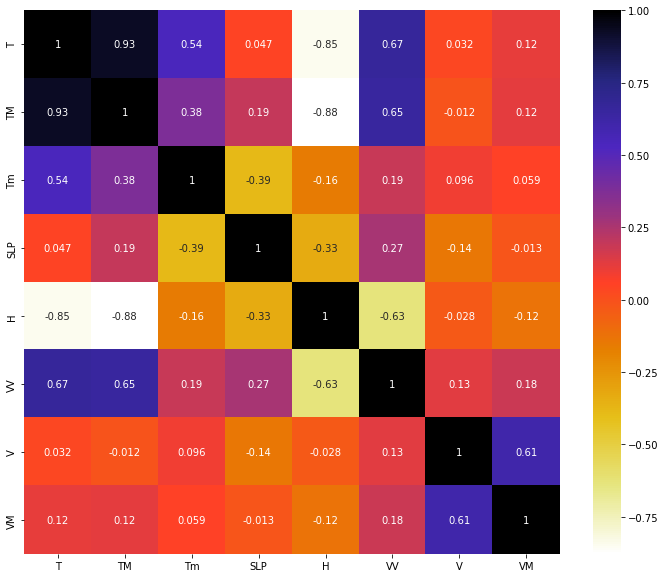

In [ ]:
#Plotting the correlation between the input features
import seaborn as sns
import matplotlib.pyplot as plt
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
#removing highly correlated features
def correlation(dataset,threshold):
  col_corr = set() #set all the names of correlated columns
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if (corr_matrix.iloc[i,j])>threshold: #we are interested in absolute correlation value
         colname = corr_matrix.columns[i] #getting the name of the column
         col_corr.add(colname)
  return col_corr



In [ ]:
corr_features = correlation(X_train, 0.90)
len(set(corr_features))

1

In [ ]:
corr_features

{'TM'}

In [ ]:
#X.drop(corr_features, axis=1)
X_test.drop(corr_features, axis=1)
X_train.drop(corr_features, axis=1)

,month,T,Tm,SLP,H,VV,V,VM
529,9.0,26.3,23.8,1004.0,85.0,2.6,9.1,22.2
1676,4.0,31.9,20.0,1005.0,36.0,5.1,10.9,29.4
1730,6.0,28.8,23.0,1000.4,70.0,3.9,6.1,77.8
988,6.0,24.5,22.8,996.7,92.0,2.3,13.9,25.9
182,9.0,25.5,18.7,1007.2,78.0,3.1,3.9,9.4
...,...,...,...,...,...,...,...,...
1130,5.0,26.2,21.0,1003.6,54.0,3.2,13.5,27.8
1294,4.0,22.5,18.8,1012.7,75.0,3.1,6.7,14.8
860,8.0,25.6,22.6,1000.2,87.0,2.7,3.5,7.6
1459,9.0,26.7,21.2,1006.2,60.0,3.5,2.2,9.4


In [ ]:
#Storing the dataframe 'X' as 'X1' after dropping highly corelated attribute.
X1=X.drop(corr_features, axis=1)
print(X1)

         T    Tm     SLP     H   VV     V    VM
0     24.9  16.3  1007.3  49.0  4.0   4.3  11.1
1     26.3  18.4  1007.6  41.0  4.0   3.0   7.6
2     25.5  18.6  1007.9  51.0  4.0   7.4  22.2
3     22.6  14.6  1009.7  63.0  4.0  12.0  14.8
4     22.2  16.6  1012.9  58.0  4.0   8.1  14.8
...    ...   ...     ...   ...  ...   ...   ...
1825  27.8  22.0  1002.6  77.0  3.2   5.0   7.6
1826  25.9  22.0  1002.6  86.0  2.9   4.1  13.0
1827  26.5  22.2  1002.6  82.0  2.9   4.4  11.1
1828  24.8  20.2  1002.6  91.0  2.6   3.5  11.1
1829  26.3  20.0  1002.6  83.0  3.7   2.8   9.4

[1830 rows x 7 columns]


In [ ]:
#Splitting the dataframe X1
X1_train, X1_test, y_train, y_test = train_test_split(X1,y, test_size=0.2, random_state=42)
X1_train.shape, X1_test.shape

((1464, 7), (366, 7))

#**Normalisation and PCA :**

In [ ]:
#Normalisation using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)



#implementing PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)
scaled_data.shape



(1830, 8)

In [ ]:
X_pca.shape

(1830, 2)

In [ ]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
#df=pd.DataFrame(y_train)
#df.isnull().any().any()
#X_train_pca.shape

[0. 0. 1. ... 1. 1. 0.]


Text(0, 0.5, 'Second principle component')

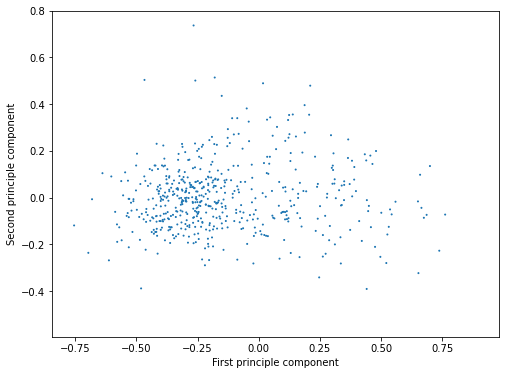

In [ ]:
#Plotting PCA attributes
import matplotlib.pyplot as plt
arr = y.to_numpy()
print(arr)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0],X_pca[:,1], arr)
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

#**Implementing Logistic Regression :**

In [ ]:
#implementing Logistic Regression with PCA
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_pca, y_train)
model.score(X_test_pca, y_test)

0.6994535519125683

In [ ]:
#Implementing Logistic Regression on X1 dataframe i.e. after dropping 'TM' because it was highly corelated with 'T'
model = LogisticRegression()
model.fit(X1_train, y_train)
model.score(X1_test, y_test)
#model.score(X1_train, y_train)

0.7240437158469946

In [ ]:
#Logistic Regression without using PCA, on original dataframe
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7841530054644809

In [ ]:
#Implementing Bagging ensemble on Logistic Regression Classifier
from sklearn.ensemble import BaggingClassifier
bagging_clf = BaggingClassifier(base_estimator = LogisticRegression(), n_estimators = 100, max_features = 8, random_state = 42)
bagging_clf.fit(X_train, y_train).score(X_test, y_test)

0.7841530054644809

#**Implementing SVM Linear Kernel :**

In [ ]:
#implementing SVM linear kernel with PCA
from sklearn.svm import SVC
classifier = SVC (kernel="linear")
classifier.fit(X_train_pca, y_train)

SVC(kernel='linear')

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = classifier.predict(X_test_pca)
accuracy_score(y_test,y_pred)

0.7103825136612022

In [ ]:
#Implementing SVM on X1 dataframe i.e. after dropping 'TM' because it was highly corelated with 'T'
classifier = SVC (kernel="linear")
classifier.fit(X1_train, y_train)
y_pred = classifier.predict(X1_test)
accuracy_score(y_test,y_pred)

0.7213114754098361

In [ ]:
#Implementing SVM  on dataframe 'X', i.e. original dataframe
classifier = SVC (kernel="linear")
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test,y_pred)

0.7814207650273224

#**Implementing Random Forest :**

In [ ]:
#Implementing Random Forest on PCA dataframe
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
rf_clf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_pca, y_train)
rf_clf.score(X_test_pca, y_test)

0.6256830601092896

In [ ]:
#Implementing Random Forest on X1 dataframe i.e. after dropping 'TM' because it was highly corelated with 'T'
rf_clf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clf.fit(X1_train, y_train)
rf_clf.score(X1_test, y_test)

0.7240437158469946

#**Best Result from Random Forest :**

In [ ]:
#Implementing Random Forest on X dataframe, i.e. original dataframe 
rf_clf = ensemble.RandomForestClassifier(n_estimators=1000)
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

0.7622950819672131

#**Hyperparameter Tuning on Random Forest :**

In [ ]:
#Hyperparameter tuning using GridSearchCV on X dataframe
rf_clf = ensemble.RandomForestClassifier(n_jobs=-1)
param_grid = {
    "n_estimators" : [100,200],
    "max_depth": [5,7,11],
    "criterion": ["gini", "entropy"],    
}

model = model_selection.GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    scoring="accuracy",
    verbose=10,
    n_jobs=1,
    cv=5,
)

model.fit(X,y)
print(model.best_score_)
print(model.best_estimator_.get_params())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START criterion=gini, max_depth=5, n_estimators=100..............
[CV 1/5; 1/12] END criterion=gini, max_depth=5, n_estimators=100;, score=0.735 total time=   1.5s
[CV 2/5; 1/12] START criterion=gini, max_depth=5, n_estimators=100..............
[CV 2/5; 1/12] END criterion=gini, max_depth=5, n_estimators=100;, score=0.738 total time=   0.4s
[CV 3/5; 1/12] START criterion=gini, max_depth=5, n_estimators=100..............
[CV 3/5; 1/12] END criterion=gini, max_depth=5, n_estimators=100;, score=0.730 total time=   0.4s
[CV 4/5; 1/12] START criterion=gini, max_depth=5, n_estimators=100..............
[CV 4/5; 1/12] END criterion=gini, max_depth=5, n_estimators=100;, score=0.699 total time=   0.4s
[CV 5/5; 1/12] START criterion=gini, max_depth=5, n_estimators=100..............
[CV 5/5; 1/12] END criterion=gini, max_depth=5, n_estimators=100;, score=0.658 total time=   0.4s
[CV 1/5; 2/12] START criterion=gini, max_dep

In [ ]:
#Performing Hyperparameter Tuning by RandomizedSearch
param_grid = {
    "n_estimators" : np.arange(100, 1500, 100),
    "max_depth": np.arange(1,20),
    "criterion": ["gini", "entropy"],    
}

model = model_selection.RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_grid,
    n_iter=10,
    scoring="accuracy",
    verbose=10,
    n_jobs=1,
    cv=5,
)

model.fit(X,y)
print(model.best_score_)
print(model.best_estimator_.get_params())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START criterion=entropy, max_depth=4, n_estimators=600...........
[CV 1/5; 1/10] END criterion=entropy, max_depth=4, n_estimators=600;, score=0.699 total time=   1.7s
[CV 2/5; 1/10] START criterion=entropy, max_depth=4, n_estimators=600...........
[CV 2/5; 1/10] END criterion=entropy, max_depth=4, n_estimators=600;, score=0.708 total time=   1.7s
[CV 3/5; 1/10] START criterion=entropy, max_depth=4, n_estimators=600...........
[CV 3/5; 1/10] END criterion=entropy, max_depth=4, n_estimators=600;, score=0.708 total time=   1.7s
[CV 4/5; 1/10] START criterion=entropy, max_depth=4, n_estimators=600...........
[CV 4/5; 1/10] END criterion=entropy, max_depth=4, n_estimators=600;, score=0.697 total time=   1.7s
[CV 5/5; 1/10] START criterion=entropy, max_depth=4, n_estimators=600...........
[CV 5/5; 1/10] END criterion=entropy, max_depth=4, n_estimators=600;, score=0.672 total time=   1.6s
[CV 1/5; 2/10] START criterio

In [ ]:
#Hyperparameter Tuning using Bayesian Optimizaion with Gaussian process
from functools import partial
from skopt import space
from skopt import gp_minimize
from sklearn import ensemble
from sklearn import model_selection

def optimize(params, param_names, x,y):
  params = dict(zip(param_names, params))
  model = ensemble.RandomForestClassifier(**params)
  kf = model_selection.StratifiedKFold(n_splits=5)
  accuracies = []
  for idx in kf.split(X=x,y=y):
    train_idx, test_idx = idx[0], idx[1]
    xtrain = x.iloc[train_idx]
    ytrain = y[train_idx]
    xtest = x.iloc[test_idx]
    ytest = y[test_idx]
   
    model.fit(xtrain, ytrain)
    preds = model.predict(xtest)
    fold_acc = metrics.accuracy_score(ytest, preds)
    accuracies.append(fold_acc)
  
  return -1.0 * np.mean(accuracies)


# df = pd.read_excel('/content/drive/MyDrive/Data_Set1.xlsx')
df = pd.read_excel('Data_Set1.xlsx')
X=df.drop(labels=['Unnamed: 0', 'Day', 'TS'], axis=1)
#print(X)
y=df['TS'] 

param_space = [
                space.Integer(3, 15, name="max_depth"),
                space.Integer(100,600, name="n_estimators"),
                space.Categorical(["gini", "entropy"], name="criterion"),
                space.Real(0.01, 1, prior="uniform", name="max_features")
]
param_names = [
              "max_depth",
              "n_estimators",
              "criterion",
              "max_features"
]

optimization_function = partial(
    optimize,
    param_names=param_names,
    x=X,
    y=y
)

result = gp_minimize(
    optimization_function,
    dimensions=param_space,
    n_calls=15,
    n_random_starts=10,
    verbose=10,
)

print(dict(zip(param_names, result.x)))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.0975
Function value obtained: -0.7033
Current minimum: -0.7033
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.1620
Function value obtained: -0.7186
Current minimum: -0.7186
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.5427
Function value obtained: -0.7066
Current minimum: -0.7186
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 10.4201
Function value obtained: -0.7175
Current minimum: -0.7186
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 8.6117
Function value obtained: -0.7115
Current minimum: -0.7186
Iteration No: 6 started.

#**Implementing Gradient Boosting Classifier :**

In [ ]:
#Implementing GB classifier on X1 dataframe, i.e. dataframe after removing the highly corelated attribute - 'TM'
gb_clf = ensemble.GradientBoostingClassifier(n_estimators=100)
gb_clf.fit(X1_train, y_train)
gb_clf.score(X1_test, y_test)

0.73224043715847

In [ ]:
#Implementing GB classifier on X dataframe, i.e. original dataframe
gb_clf = ensemble.GradientBoostingClassifier(n_estimators=100)
gb_clf.fit(X_train, y_train)
gb_clf.score(X_test, y_test)

0.76775956284153

#**Implementing XGBoost :**

In [ ]:
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier





In [ ]:
XGBClassifier().get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
#Implementing XGBoost classifier on PCA dataframe
model_xgboost = xgboost.XGBClassifier(base_score=0.5,
                                      booster='gbtree',
                                      colsample_bylevel=1,
                                      colsample_bynode=1,
                                      colsample_bytree=1,
                                      learning_rate=0.1,
                                      max_depth=3,
                                      min_child_weight=1,
                                      n_estimators=100,
                                      n_jobs=1,
                                      reg_lambda=1,
                                      scale_pos_weight=1,
                                      subsample=1,
                                      eval_metric='auc',
                                      verbosity=1)
eval_set =[(X_test_pca, y_test)]
model_xgboost.fit(X_train_pca,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.598966
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.629554
[2]	validation_0-auc:0.629064
[3]	validation_0-auc:0.635051
[4]	validation_0-auc:0.635522
[5]	validation_0-auc:0.639332
[6]	validation_0-auc:0.639405
[7]	validation_0-auc:0.63643
[8]	validation_0-auc:0.639605
[9]	validation_0-auc:0.639568
[10]	validation_0-auc:0.639423
[11]	validation_0-auc:0.639568
[12]	validation_0-auc:0.639731
[13]	validation_0-auc:0.641763
[14]	validation_0-auc:0.641509
[15]	validation_0-auc:0.64111
[16]	validation_0-auc:0.641201
[17]	validation_0-auc:0.641709
[18]	validation_0-auc:0.64189
[19]	validation_0-auc:0.64639
[20]	validation_0-auc:0.646335
[21]	validation_0-auc:0.644811
[22]	validation_0-auc:0.644739
[23]	validation_0-auc:0.650544
[24]	validation_0-auc:0.644485
[25]	validation_0-auc:0.643922
[26]	validation_0-auc:0.660051
[27]	validation_0-auc:0.659742
[28]	validation_0-auc:0.659561
[29]	validation_0-auc:0.659452
[30]	validation_0-au

XGBClassifier(eval_metric='auc')

In [ ]:
#Evaluating model performance on PCA dataframe
y_train_pred=model_xgboost.predict_proba(X_train_pca)[:,1]
y_test_pred=model_xgboost.predict_proba(X_test_pca)[:,1]
print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_test, y_test_pred)))

AUC Train: 0.7099
AUC Valid: 0.6603


#**Best Result from XGBoost :**

In [ ]:
#Implementing XGboost on X dataframe, i.e. original dataframe 
model_xgboost = xgboost.XGBClassifier(base_score=0.5,
                                      booster='gbtree',
                                      colsample_bylevel=1,
                                      colsample_bynode=1,
                                      colsample_bytree=1,
                                      learning_rate=0.1,
                                      max_depth=3,
                                      min_child_weight=1,
                                      n_estimators=100,
                                      n_jobs=1,
                                      reg_lambda=1,
                                      scale_pos_weight=1,
                                      subsample=1,
                                      eval_metric='auc',
                                      verbosity=1)
eval_set =[(X_test, y_test)]
model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.684634
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.708073
[2]	validation_0-auc:0.755134
[3]	validation_0-auc:0.753901
[4]	validation_0-auc:0.791255
[5]	validation_0-auc:0.782384
[6]	validation_0-auc:0.780624
[7]	validation_0-auc:0.771517
[8]	validation_0-auc:0.777939
[9]	validation_0-auc:0.780461
[10]	validation_0-auc:0.792707
[11]	validation_0-auc:0.796499
[12]	validation_0-auc:0.803157
[13]	validation_0-auc:0.80352
[14]	validation_0-auc:0.804808
[15]	validation_0-auc:0.803901
[16]	validation_0-auc:0.809071
[17]	validation_0-auc:0.806912
[18]	validation_0-auc:0.808908
[19]	validation_0-auc:0.811865
[20]	validation_0-auc:0.812954
[21]	validation_0-auc:0.8127
[22]	validation_0-auc:0.81221
[23]	validation_0-auc:0.814478
[24]	validation_0-auc:0.812935
[25]	validation_0-auc:0.812119
[26]	validation_0-auc:0.813679
[27]	validation_0-auc:0.814006
[28]	validation_0-auc:0.812446
[29]	validation_0-auc:0.810414
[30]	validation_0-au

XGBClassifier(eval_metric='auc')

In [ ]:
#Evaluating model performance for dataframe 'X'
y_train_pred=model_xgboost.predict_proba(X_train)[:,1]
y_test_pred=model_xgboost.predict_proba(X_test)[:,1]
print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_test, y_test_pred)))

AUC Train: 0.8510
AUC Valid: 0.8145


#**Implementing Multi Layer Perceptron :**

In [ ]:
#Splitting dataset into 80-20 train-test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


#Training MLP
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (6,4,1), max_iter=500, activation='relu')
mlp
mlp.fit(X_train,y_train)
pred = mlp.predict(X_test)
#pred

In [ ]:
#Printing the confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(y_test, pred)

array([[260,   0],
       [106,   0]])

In [ ]:
#Printing classification_report for MLP
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83       260
         1.0       0.00      0.00      0.00       106

    accuracy                           0.71       366
   macro avg       0.36      0.50      0.42       366
weighted avg       0.50      0.71      0.59       366

